# SimuFileHandlerの使い方サンプル（空間進化ゲーム）
ここでは進化ゲームの応用の一種である空間進化ゲームを例にとってsimu_file_handlerの使い方を解説する．

進化ゲームのシナリオは次のようになっている．
* L×Lの格子上に隙間なくエージェントを配置し，ゲーム・戦略更新を行わせる
* 2人ゲームによる利得は以下のように決まる：
    - 両者協力 (C,C)：R
    - 自分協力，相手非協力 (C,D)：S
    - 自分非協力，相手協力 (D,C)：T
    - 両者非協力 (D,D)：P
* 1世代あたりの処理は以下：
    1. 全エージェントからランダムに1人選ぶ（エージェントA）．
    2. Aは近傍とゲームを行い，Aの近傍たちもまたそれぞれの近傍とゲームを行う．
    3. Aは自分自身と近傍を含めた中で最も大きい利得を得たエージェントの戦略を確率 1-μ でまねる．残りの μ では戦略を反転させる．
    4. 繰り返しのカウント数を1増加．繰り返し数が L×L であれば1世代終了，それより小さいなら 1. に戻る (合計L×L回やる)．

## 必要なライブラリをインポート

In [26]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../")
import simu_file_handler as sh   # simu_file_handler を読み込む

import importlib
importlib.reload(sh)

<module 'simu_file_handler' from '../simu_file_handler.py'>

## Parameterクラスを定義
今回の変数は以下：
* L : 格子の一辺の大きさ．したがってエージェント数はL×Lで計算される．
* T : （非協力，協力）のときの利得
* S : （協力，非協力）のときの利得
* mu : 突然変異率．突然変異すると戦略が反転する．
* Tmax : 世代の繰り返し数．

今回は利得行列のパラメータ4つ（R,S,T,P）のうち，SとTのみ変数扱いとして，残りのRとPはそれぞれ1,0で固定とする．

In [27]:
R, P = 1., 0.

class Parameter(sh.SParameter):
    
    # 初期化（最低この関数だけはオーバーライドすること！）
    def __init__(self, L=20, T=1.4, S=-0.4, mu=0.01, Tmax=1000, sd=None):
        super().__init__(sd)
        
        self.pdict['L'] = L
        self.pdict['T'] = T
        self.pdict['S'] = S
        self.pdict['mu'] = mu
        self.pdict['Tmax'] = Tmax

## SimuFileHandlerクラスのインスタンスを生成

In [28]:
# 指定したディレクトリがない場合は作られる
sfh = sh.SimuFileHandler('data_eg', Parameter())

## 進化ゲームのクラスを定義

In [59]:
class EvolGame:
    
    # 初期化メソッド
    def __init__(self, param):
        self.param = param
        L = self.param.get('L')
        
        self.G = nx.grid_2d_graph(L, L, True)
        self.nodes = {n:{'strategy':'C','payoff':0.} for n in self.G.nodes}
        
        self.reset()
    
    
    # エージェントを初期状態にリセットする
    def reset(self):
        self.t = 0
        
        for d in self.nodes.values():
            d['strategy'] = 'C' if np.random.rand() < 0.5 else 'D'
            d['payoff'] = 0.
    
    
    # 注目しているエージェントがその近傍とゲームし，近傍もまた自分自身の近傍とゲームをする
    def play_game(self, f_i):
        global R, P
        T, S = self.param.get('T'), self.param.get('S')
        
        game = lambda mys, ops: {('C','C'):R, ('C','D'):S, ('D','C'):T, ('D','D'):P}[(mys,ops)]
        
        self.nodes[f_i]['payoff'] = 0.
        mys = self.nodes[f_i]['strategy']
        for a  in self.G.neighbors(f_i):
            ops = self.nodes[a]['strategy']
            self.nodes[f_i]['payoff'] += game(mys, ops)
            
            self.nodes[a]['payoff'] = 0.
            for aa in self.G.neighbors(a):
                ops2 = self.nodes[aa]['strategy']
                self.nodes[a]['payoff'] += game(ops, ops2)
    
    
    # 確率 μ：戦略を反転させる
    # 確率 1-μ：自分＋近傍の中で最も高い利得を得たエージェントの戦略をまねる
    def update_strategy(self, f_i):
        #mu = self.pd['mu']
        mu = self.param.get('mu')
        
        if np.random.rand() < mu:
            self.nodes[f_i]['strategy'] = 'C' if np.random.rand() < 0.5 else 'D'
        else:
            nlist = list([n for n in self.G.neighbors(f_i)])
            nlist.append(f_i)
        
            np.random.shuffle(nlist)#; print(nlist)
            imax = 0; rmax = self.nodes[nlist[0]]['payoff']
            for i in range(1,len(nlist)):
                if self.nodes[nlist[i]]['payoff'] > rmax:
                    imax = i
                    rmax = self.nodes[nlist[i]]['payoff']

            self.nodes[f_i]['strategy'] = self.nodes[nlist[imax]]['strategy']
    
    
    # 協力者割合を求める
    def calc_fc(self):
        L = self.param.get('L')
        N = int(L**2)
        nc = 0
        for d in self.nodes.values():
            nc += 1 if d['strategy']=='C' else 0
        
        return nc/N
    
    
    # 1世代分の処理を行う
    def execute_one_generation(self):
        L = self.param.get('L')
        N = L*L
        
        for i in range(N):
            r = np.random.randint(N)
            f_i = (r//L,r%L)
            self.play_game(f_i)
            self.update_strategy(f_i)
    
    
    # Tmax世代行い，最後の1割の世代での協力者割合の平均値を返す
    def execute(self, show=False, fs='', bs='', end='\n'):
        L = self.param.get('L')
        N = int(L**2)
        Tmax = self.param.get('Tmax')
        arr = np.zeros(Tmax)
        
        pg = ProgressGen(Tmax, 10, fs, bs, end, clear=True)
        for i in range(Tmax):
            self.execute_one_generation()
            arr[i] = self.calc_fc()
            
            if show:
                pg.show(i)
        
        #print()
        return np.sum(arr[int(N*0.9):])/(N-int(N*0.9))   
            
            
            
# プログレスバーの表示用
class ProgressGen(object):
    def __init__(self, MAX_ITER, length, fs='', bs='', end='\n', clear=False):
        self.max_iter = MAX_ITER
        self.length = length
        self.fs = fs
        self.bs = bs
        self.end = '\r'
        self.lend = end
        
        if clear == True:
            self.fs = '\r' + ' '*(len(fs)+1+length+1+4+1+len(bs)) + '\r' + self.fs
            
        if len(fs) > 0:
            self.fs = fs + ' '
        
        print(fs + "_"*length, f"{0:3d}%", bs, end='\r')
        
    def show(self, i):
        i += 1
        t = self.max_iter / self.length
        if i%t == 0:
            print(self.fs + "*"*int(i/t) + "_"*(self.length-int(i/t)), \
                  f"{int(i/self.max_iter*100):3d}%", self.bs, end=(self.end if i<self.max_iter else self.lend))

## 進化ゲームを一度動作させる

In [58]:
# パラメータを用意
param = Parameter(); print(param)

eg = EvolGame(param)         # 進化ゲームを初期化
fc = eg.execute(show=True)  # 実行

print(fc)

L=20_T=1.400000E+00_S=-4.000000E-01_mu=1.000000E-02_Tmax=1000
********** 100%  
0.0796875


## TとSを変動させて協力者割合を調査する

In [60]:
n = 1

# パラメータを用意
tmp_param = Parameter(Tmax=500)

# 変数を動かす範囲を定義
S_array = np.arange(-1.0, 1.05, 0.2)
T_array = np.arange(0.0,  2.05, 0.2)

# ParamIteratorを使ってSを変動させたパラメータクラスのインスタンスを次々生成させる
for S_param in sh.ParamIterator(tmp_param, 'S', S_array):
    # 上記と同様にTを変動させたものを次々生成
    for T_param in sh.ParamIterator(S_param, 'T', T_array):
        #print(T_param)
        eg = EvolGame(T_param)  # 初期化
        for i in range(n):
            eg.reset()          # エージェントをリセット
            fc = eg.execute(show=True, fs=T_param.__str__(), end='\r\n')  # 実行
            sfh.add_one_result(T_param, [fc])                  # add_one_resultを用いて結果を蓄積

print()
print('finished!')

L=20_T=0.000000E+00_S=-1.000000E+00_mu=1.000000E-02_Tmax=500 ********** 100% 
L=20_T=2.000000E-01_S=-1.000000E+00_mu=1.000000E-02_Tmax=500 ********** 100% 
L=20_T=4.000000E-01_S=-1.000000E+00_mu=1.000000E-02_Tmax=500 ********** 100% 
L=20_T=6.000000E-01_S=-1.000000E+00_mu=1.000000E-02_Tmax=500 ********** 100% 
L=20_T=8.000000E-01_S=-1.000000E+00_mu=1.000000E-02_Tmax=500 ********** 100%   30% 
L=20_T=1.000000E+00_S=-1.000000E+00_mu=1.000000E-02_Tmax=500 ********** 100% 
L=20_T=1.200000E+00_S=-1.000000E+00_mu=1.000000E-02_Tmax=500 ********** 100% 
L=20_T=1.400000E+00_S=-1.000000E+00_mu=1.000000E-02_Tmax=500 ********** 100% 
L=20_T=1.600000E+00_S=-1.000000E+00_mu=1.000000E-02_Tmax=500 ********** 100% 
L=20_T=1.800000E+00_S=-1.000000E+00_mu=1.000000E-02_Tmax=500 ********** 100% 
L=20_T=2.000000E+00_S=-1.000000E+00_mu=1.000000E-02_Tmax=500 ********** 100% 
L=20_T=0.000000E+00_S=-8.000000E-01_mu=1.000000E-02_Tmax=500 ********** 100% 
L=20_T=2.000000E-01_S=-8.000000E-01_mu=1.000000E-02_Tmax=5

L=20_T=1.000000E+00_S=8.000000E-01_mu=1.000000E-02_Tmax=500 ********** 100% 
L=20_T=1.200000E+00_S=8.000000E-01_mu=1.000000E-02_Tmax=500 ********** 100%   20% 
L=20_T=1.400000E+00_S=8.000000E-01_mu=1.000000E-02_Tmax=500 ********** 100% 
L=20_T=1.600000E+00_S=8.000000E-01_mu=1.000000E-02_Tmax=500 ********** 100% 
L=20_T=1.800000E+00_S=8.000000E-01_mu=1.000000E-02_Tmax=500 ********** 100% 
L=20_T=2.000000E+00_S=8.000000E-01_mu=1.000000E-02_Tmax=500 ********** 100% 
L=20_T=0.000000E+00_S=1.000000E+00_mu=1.000000E-02_Tmax=500 ********** 100% 
L=20_T=2.000000E-01_S=1.000000E+00_mu=1.000000E-02_Tmax=500 ********** 100% 
L=20_T=4.000000E-01_S=1.000000E+00_mu=1.000000E-02_Tmax=500 ********** 100% 
L=20_T=6.000000E-01_S=1.000000E+00_mu=1.000000E-02_Tmax=500 ********** 100% 
L=20_T=8.000000E-01_S=1.000000E+00_mu=1.000000E-02_Tmax=500 ********** 100% 
L=20_T=1.000000E+00_S=1.000000E+00_mu=1.000000E-02_Tmax=500 ********** 100% 
L=20_T=1.200000E+00_S=1.000000E+00_mu=1.000000E-02_Tmax=500 **********

## Tのみを動かしたときのPDゲームにおける協力者割合変化を読み込んでプロット

L=20_T=1.400000E+00_S=-4.000000E-01_mu=1.000000E-02_Tmax=500
attempts: 3


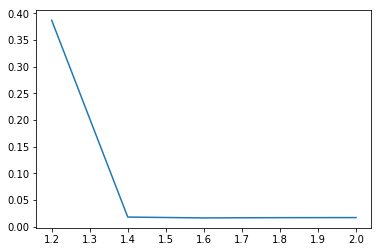

In [61]:
# 基本となるパラメータを用意
tmp_param = Parameter(S=-0.4, Tmax=500); print(tmp_param)

# Tを動かす範囲を定義
T_array = np.arange(1.2,  2.05, 0.2)

# get_ave_1Dを用いてTを動かしたときの結果の値を取得する
# 末尾の[0]は結果の値の中でも最初のものを取得するため（協力者割合や平均利得など結果の量として色々見たい場合もある）
result = sfh.get_ave_1D(tmp_param, 'T', T_array)[0]  

plt.plot(T_array, result)

## TとSを動かしたときの協力者割合をカラーマップでプロット

L=20_T=1.400000E+00_S=-4.000000E-01_mu=1.000000E-02_Tmax=500


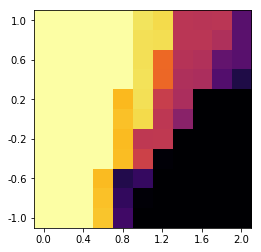

In [62]:
tmp_param = Parameter(S=-0.4, Tmax=500); print(tmp_param)

S_array = np.arange(-1.0, 1.05, 0.2)
T_array = np.arange(0.0,  2.05, 0.2)

# get_ave_2Dで2つのパラメータを変化させたときの結果を配列の形で取得
result = sfh.get_ave_2D(tmp_param, 'T', 'S', T_array, S_array, show=False)[0,:,:]

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)

ax.set_xticks(range(0,11,2))
ax.set_yticks(range(0,11,2))

ax.set_xticklabels(np.round(T_array[::2], 1))
ax.set_yticklabels(np.round(S_array[::2], 1))
ax.imshow(result, origin='lower', cmap='inferno')

## フォルダ内の状況を確認

Folder: data_eg
Parameter: ['L', 'T', 'S', 'mu', 'Tmax']

# of files: 121
Total attemps: 362

# of values that was set to each variable. 


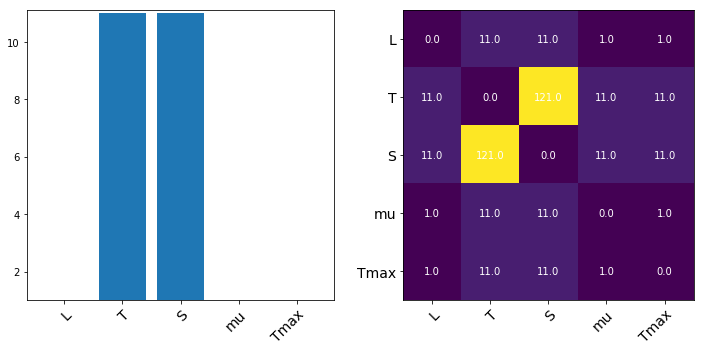

In [63]:
sfh.summary()